In [1]:
from asapdiscovery.data.backend.openeye import load_openeye_pdb, load_openeye_sdf,combine_protein_ligand, save_openeye_pdb
from asapdiscovery.modeling.modeling import superpose_molecule
from openeye import oechem
from pymol import cmd
from pathlib import Path
import os
import re
from rdkit import DataStructs
import numpy as np

## Load in all the generated structures

In [2]:
results_folder = Path("/home/pengs/fold_zika/results/")

In [3]:
# Function to find all pdb files in a directory
def find_pdb_files(folder_path):
    pdb_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".pdb"):
                pdb_files.append(os.path.join(root, file))
    return pdb_files


In [4]:
pdb_files = find_pdb_files(results_folder)

## Group the ligands based on the sequence input

In [5]:
def find_name_in_file(pattern, path):
    # Use re.search to find the pattern in the path
    match = re.search(pattern, path)
    
    # Check if there is a match
    if match:
        id = match.group(1)
        return(id)
    else:
        print(path)
        print("No match found.")

In [6]:
# Dictionary with the input sequence id as key and the different generated structures as values
sequence_folds = dict()
pattern = r'results/(.+\.\d)_\d+'

for pdb in pdb_files:
    sequence = find_name_in_file(pattern, pdb)
    if sequence: 
        if sequence in sequence_folds:
            sequence_folds[sequence].append(pdb)
        else:
            sequence_folds[sequence] = [pdb]

## Align folded structures to template structure and retain the one with lowest RMSD
https://github.com/choderalab/asapdiscovery/blob/main/asapdiscovery-modeling/asapdiscovery/modeling/modeling.py#L225-L243

In [7]:
# template = path to template file
# results = list of paths to the results
# Return the new aligned molecule (OEGraphMol) and lowest rmsd
def find_pdb_low_rmsd(ref, results):
    lowest = 100
    the_pdb = ''
    best_fit = ''
    # Iterate through the different structures generated and calculate RMSD
    for pdb_file in results:
        fit = load_openeye_pdb(pdb_file)
        # Will save best aligned openeye molecule
        align = superpose_molecule(ref,fit, ref_chain = 'B')[0]
        rmsd = superpose_molecule(ref,fit, ref_chain = 'B')[1]
        if rmsd < lowest:
            lowest = rmsd
            the_pdb = pdb_file
            best_fit = align
    # Return this in a list so better find
    # Return the aligned structure and pdb file with the lowest rmsd value
    return [best_fit, the_pdb, lowest]

In [8]:
# Load in the reference template
template = "/home/pengs/fold_zika/template_dir/zikv.pdb"
ref = load_openeye_pdb(results_folder/template)

In [9]:
only_prot = Path('/home/pengs/fold_zika/only_prot')

In [14]:
# save the best alignments and rmsd in a Dictionary
best = dict()
for id in sequence_folds:
    folds = sequence_folds[id]
    best[id] = find_pdb_low_rmsd(ref, folds)
    # Save just the aligned protein in file in protein directory
    prot_file = id + ".pdb"
    save_openeye_pdb(best[id][0], only_prot / prot_file)

In [15]:
best

{'YP_001531172.2': [<oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x2b4dcf6678d0> >,
  '/home/pengs/fold_zika/results/YP_001531172.2_24767_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_24767.pdb',
  0.8701036598468331],
 'NP_776018.1': [<oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x2b4dcf667870> >,
  '/home/pengs/fold_zika/results/NP_776018.1_3362_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_3362.pdb',
  0.7650077072824754],
 'NP_740321.1': [<oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x2b4dcf667c90> >,
  '/home/pengs/fold_zika/results/NP_740321.1_28211_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_28211.pdb',
  0.7797046423674694],
 'NP_722463.1': [<oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x2b4dcf6679c0> >,
  '/home/pengs/fold_zika/results/NP_722463.1_23188_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_23188.pdb',
  0.7798746246757736],
 'YP_001527884.1': [

## Plot out the RMSD values
Of the C alpha 

In [16]:
# importing matplotlib module 
from matplotlib import pyplot as plt

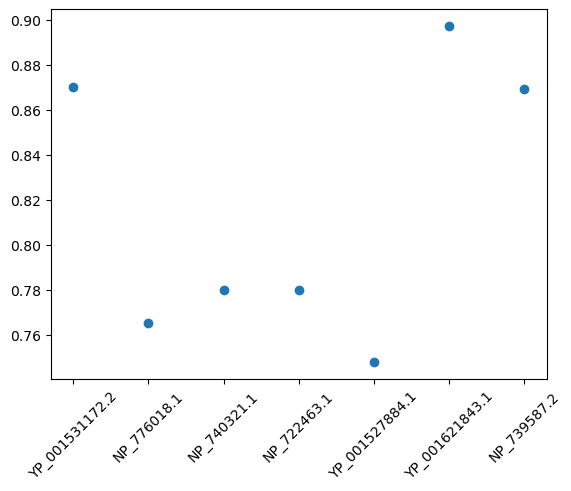

In [19]:
# https://www.geeksforgeeks.org/python-introduction-matplotlib/
# x-axis values
x = [] 
# Y-axis values
y = []
# Generate the x and y values
for id in best:
    # Fill x with the protein id being folded (id of sequence)
    x.append(id)
    # Fill y with rmsd value
    y.append(best[id][2])
 
# Function to plot scatter using plot() method
plt.xticks(rotation=45)
plt.plot(x, y, 'o')

# Save the plot
plt.savefig('1chain_YP0016.png')
# function to show the plot
plt.show()

## Put the fragments back in the same pose to the generated structures

In [22]:
# Path to the fragments
frags_directory = Path("/home/pengs/fold_zika/lig_sdfs/")
combine_directory = Path("/home/pengs/fold_zika/combined/")

In [25]:
lig_pattern = r'(lig_\d+)\.sdf'

for seq in best:
    # Load in the aligned OEMol protein
    prot = best[seq][0]
    # Make a new directory to store all the newly posed fragments in the new protein
    os.mkdir(combine_directory/seq)
    
    # Read in the fragments in the file
    for root, dirs, files in os.walk(frags_directory):
        for fragment in files:
            # Find the name of the ligand
            match = re.match(lig_pattern, fragment)
            lig_name = match.group(1)
            # Load in the fragment as OE object
            lig = load_openeye_sdf(frags_directory/fragment)
            lig_protein = combine_protein_ligand(prot, lig)
            # Save in file in new directory
            output_file = seq + "_" + lig_name + ".pdb"
            save_openeye_pdb(lig_protein, combine_directory / seq / output_file)

## Add hydrogen and separate the protein and ligand

command line run within asapdiscovery environmet: 
asap-prep protein-prep --target ZIKV-NS2B-NS3pro --pdb-file NP_722463.1_lig_5.pdb --output-dir prepped_test --align NP_722463.1_lig_5.pdb --use-dask

## Loop through generated combinatory files and generate structure for each

In [11]:
# Return a list of all the files
def traverse_files(directory):
    all_files = []
    # Traverse files within a directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            all_files.append(file)
    return all_files

### Dumbest process of just writing out all the commands for all the generated pdb structures for prepping
### Does not prep all the files, are trying other methods for those that does not prep

In [14]:
command = 'asap-prep protein-prep --target ZIKV-NS2B-NS3pro'
file_command = ' --pdb-file'
output_command = ' --output-dir'
align_command = ' --align'
folder = ' /home/pengs/fold_zika/combined/'
append = ' --ref-chain B --active-site-chain B --use-dask'

# Get all the different commands into a single file since somehow only works when submit individually
run_file = Path("/home/pengs/fold_zika/")
with open(run_file/'prep_files.sh','w') as f:
    f.write('#!/bin/bash\n')
    f.write('\n')
    for seq in best:
        directory_path = os.path.join(combine_directory, seq)
        path = ' ' + directory_path + '/'
        files = traverse_files(directory_path)
        for file in files:
            name = find_name_in_file(r'(.+)\.pdb', file)
            path = folder + seq + '/'
            # Save each prepped protein-ligand folder in a protein file outside current folder
            # But keep within total working directory
            output_path = folder + seq + '_prepped/'
            output_dir = name
            # command for running preparation
            cmd = command + file_command + path + file + output_command + output_path + output_dir
            cmd += align_command + path + file + append + '\n'
            f.write(cmd)
        

## Make directory files to put each of the prepared structure into

In [45]:
for seq in best:
    prepped_dir = seq + "_prepped"
    directory_path = os.path.join(combine_directory, prepped_dir)
    os.mkdir(directory_path)